In [2]:
import numpy as np
import tensorflow as tf
import math
import os
import pdb
import matplotlib.pyplot as plt
dataset = np.load('data.npy').astype(np.float32)
dataset=np.swapaxes(dataset,1,2)
dataset=np.swapaxes(dataset,2,3)
pixel_labels = np.load('clabels.npy').astype(np.int64)
pixel_labels = np.squeeze(pixel_labels)
learn_rate = 5e-3
batch_size = 238
learn_decay = 1 - 1e-5
num_epochs = 250
print(dataset.shape)
print(dataset.dtype)
print(pixel_labels.shape)
print(pixel_labels.dtype)
np.set_printoptions(threshold=np.nan)

if not os.path.exists("checkpoint_class/"):
    os.mkdir("checkpoint_class/")      

    

(36232, 50, 50, 3)
float32
(36232,)
int64


In [97]:
data1=dataset.copy()
data1[:,0,:,:] = dataset[:,1,:,:]
data1[:,1,:,:] = dataset[:,2,:,:]
data1[:,2,:,:] = dataset[:,3,:,:]

dataset=np.concatenate((dataset,data1),axis=0)
pixel_labels=np.concatenate((pixel_labels,pixel_labels),axis=0)

In [3]:
indices=np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset=dataset[indices]
pixel_labels=pixel_labels[indices]
test_data=dataset[:7200,:]
test_label=pixel_labels[:7200]
print(test_data.shape)
print(test_label.shape)
dataset=dataset[7200:,:]
pixel_labels=pixel_labels[7200:]
print(dataset.shape)
print(pixel_labels.shape)

(7200, 50, 50, 3)
(7200,)
(29032, 50, 50, 3)
(29032,)


In [4]:
tf.reset_default_graph()        
X = tf.placeholder(tf.float32, [None,50,50,3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
global_step = tf.Variable(0, trainable=False)
regularizer = tf.contrib.layers.l2_regularizer(scale=0.5)
def model(X,y,is_training):
    initializer = tf.contrib.layers.xavier_initializer()
    first_conv = tf.layers.conv2d(X, 8, 3, strides=1, padding='valid',
                                  activation=tf.nn.relu, 
                                  kernel_initializer=initializer,
                                  kernel_regularizer=regularizer,
                                  name='First_convolution')
    second_conv = tf.layers.conv2d(first_conv, 4, 3, strides=1, padding='valid',
                                  activation=tf.nn.relu, 
                                  kernel_initializer=initializer,
                                  kernel_regularizer=regularizer, 
                                  name='Second_convolution')
    max_pool = tf.layers.max_pooling2d(second_conv, 2, 2, padding='valid', name='Max_pool')
    print(max_pool.shape)
    flatten = tf.reshape(max_pool, [-1, 2116])
    #fc_layer = tf.layers.dense(flatten, 256, activation=tf.nn.relu,
                               #kernel_initializer=initializer,
                               #kernel_regularizer=regularizer,
                               #name='Dense_layer')
    fc=tf.layers.dropout(flatten, rate=0.85, training=is_training)            
    output = tf.layers.dense(fc, 2, activation=None,
                             kernel_initializer=initializer,
                             kernel_regularizer=regularizer,
                             name='Predictions')
    return output

y_out=model(X,y,is_training)
total_loss =tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=tf.one_hot(y,2))
mean_loss=tf.reduce_mean(total_loss)
learning_rate = tf.train.exponential_decay(learn_rate, global_step,
                                           1, learn_decay, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(mean_loss,global_step=global_step)

saver = tf.train.Saver(max_to_keep=1) 


(?, 23, 23, 4)


In [6]:
%matplotlib inline
def run_model(session,predict,loss_val,Xd,yd,epochs=1,batch_size=10,training=None,plot=False):
    training_now=training is not None
    train_indices=np.arange(Xd.shape[0])
    np.random.shuffle(train_indices)
    
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1]=training
    iter_cnt=0
    for e in range(epochs):
        losses=[]
        correct=0
        np.random.shuffle(train_indices)
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indices[start_idx:start_idx+batch_size]
            feed_dict={X:Xd[idx,:],y:yd[idx],is_training:training_now} 
            loss, corr, _=session.run(variables,feed_dict=feed_dict)
            losses.append(loss*batch_size)
            correct += np.sum(corr)
            iter_cnt +=1
        if plot:
            #weights=tf.get_variable('First_convolution/kernel:0')
            #pdb.set_trace()
            #x_min = tf.reduce_min(weights)
            #x_max = tf.reduce_max(weights)
            #weights_0_to_1 = (weights - x_min) / (x_max - x_min)
            #weights_0_to_255_uint8 = tf.image.convert_image_dtype (weights_0_to_1, dtype=tf.uint8)
            # to tf.image_summary format [batch_size, height, width, channels]
            #weights_transposed = tf.transpose (weights_0_to_255_uint8, [3, 0, 1, 2])
            # this will display random 3 filters from the 64 in conv1
            #tf.image_summary('conv1/filters', weights_transposed, max_images=3)
            prediction2=np.argmax(session.run(predict,feed_dict=feed_dict),1)
            count=0
            for img,pre in zip(Xd[idx,:][np.logical_not(corr),:],prediction2[np.logical_not(corr)]):
                #pdb.set_trace()
                plt.imshow(img[:,:,0])
                plt.show()
                print(pre)
                count+=1
                print(count)
                if count>50:
                    break
        total_correct = correct/Xd.shape[0]        
        total_loss = np.sum(losses)/Xd.shape[0]
        print("total_loss:{}   accuracy:{}   epoch:{}".format(total_loss,total_correct,e+1))        

with tf.Session() as sess:
    with tf.device("/gpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        num_set=int(math.ceil(dataset.shape[0]/4))
        indices=np.arange(dataset.shape[0])
        for i in range(4):
            start_idx = (i*num_set)%dataset.shape[0]
            idx = indices[start_idx:start_idx+num_set]
            validation_data=dataset[idx,:]
            validation_label=pixel_labels[idx]
            if i ==0:
                train_data=dataset[(start_idx+num_set):,:]
                train_label=pixel_labels[(start_idx+num_set):]
            else:
                train_data=np.concatenate((dataset[:start_idx,:],dataset[(start_idx+num_set):,:]))
                train_label=np.concatenate((pixel_labels[:start_idx],pixel_labels[(start_idx+num_set):]))
            print('training')
            run_model(sess,y_out,mean_loss,train_data,train_label,10,batch_size,train_step)
            print('Validation')
            run_model(sess,y_out,mean_loss,validation_data,validation_label,1,batch_size)
        savePath = saver.save(sess, 'checkpoint_class/checkpoints.ckpt')
        print('testing')
        pdb.set_trace()
        kerne=tf.get_variable('First_convolution/kernel:0')
        filter_summary = tf.image_summary(kerne)
        summary_writer = tf.train.SummaryWriter('log_filter', sess.graph_def)
        summary_writer.add_summary(filter_summary)
        run_model(sess,y_out,mean_loss,test_data,test_label,1,batch_size,plot=True)

training
total_loss:0.5165508076010673   accuracy:0.774639478276844   epoch:1
total_loss:0.3603272455048712   accuracy:0.8534490676954165   epoch:2
total_loss:0.30543097285782217   accuracy:0.8742996234040599   epoch:3
total_loss:0.2683958363558204   accuracy:0.8929916414071829   epoch:4
total_loss:0.23619856888858962   accuracy:0.906493983650225   epoch:5
total_loss:0.21076773742955174   accuracy:0.9168274088362267   epoch:6
total_loss:0.20050713941119552   accuracy:0.9214659685863874   epoch:7
total_loss:0.18439145240998744   accuracy:0.9290438137227887   epoch:8
total_loss:0.17937938906912787   accuracy:0.931156425094149   epoch:9
total_loss:0.18269461746962917   accuracy:0.9281712133737485   epoch:10
Validation
total_loss:0.1366610091275077   accuracy:0.9528795811518325   epoch:1
training
total_loss:0.17915475682961204   accuracy:0.931661614769909   epoch:1
total_loss:0.1816170496021441   accuracy:0.9323964361164692   epoch:2
total_loss:0.1712571041514977   accuracy:0.9332231101313

(Pdb) summary_writer = tf.summary.FileWriter('log_filter', sess.graph#)
*** SyntaxError: unexpected EOF while parsing
(Pdb) summary_writer = tf.summary.FileWriter('log_filter', sess.graph_def)


(Pdb) summary_writer = tf.summary.FileWriter('log_filter', sess.graph)
(Pdb) summary_writer.add_summary(image_summary_t)
*** AttributeError: 'Tensor' object has no attribute 'value'
(Pdb) image_summary = sess.run([image_summary_t])
*** tensorflow.python.framework.errors_impl.InvalidArgumentError: Cannot assign a device for operation 'convk': Could not satisfy explicit device specification '/device:GPU:0' because no supported kernel for GPU devices is available.
	 [[Node: convk = ImageSummary[T=DT_FLOAT, bad_color=Tensor<type: uint8 shape: [4] values: 255 0 0...>, max_images=3, _device="/device:GPU:0"](convk/tag, transpose)]]

Caused by op 'convk', defined at:
  File "/home/yizhe/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yizhe/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yizhe/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykern

BdbQuit: 

In [ ]:
var = [v for v in tf.global_variables() if v.name == "First_convolution/kernel:0"][0]
(Pdb) print(var)
<tf.Variable 'First_convolution/kernel:0' shape=(3, 3, 3, 8) dtype=float32_ref>
(Pdb) filter_summary = tf.image_summary(var)
*** AttributeError: module 'tensorflow' has no attribute 'image_summary'
(Pdb) x_min = tf.reduce_min(var)
(Pdb) x_max = tf.reduce_max(var)
(Pdb) kernel_0_to_1 = (var - x_min) / (x_max - x_min)
(Pdb) kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])
(Pdb) tf.image_summary('log_filter', kernel_transposed, max_images=3)

In [ ]:
10 0.3 0.75 [0.78,0.79,0.74]
15 0.3 0.75 [0.747,0.8,0.76]

10 0.3 0.85 [0.798, 0.766,0.7475]
15 0.3 0.85 [0.813, 0.774,0.759]

15 0.5 0.75 [0.793,0.767,0.77]
10 0.5 0.75 [0.795,0.736,0.78]

15 0.5 0.85 [0.706,0.788,0.814,0.786]
10 0.5 0.85 [0.855,0.82,0.76,0.794,0.804]

10 0.6 0.85 [0.736,0.75,0.8266,0.7977]
10 0.4 0.85 [0.77,0.82,0.673]

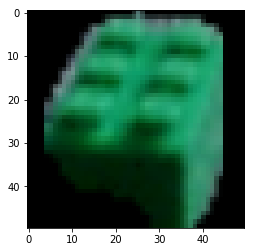

1
1


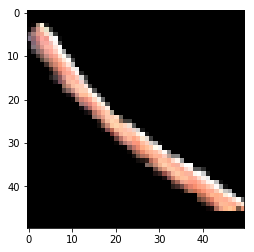

0
2


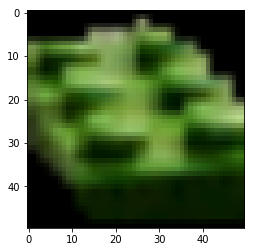

1
3


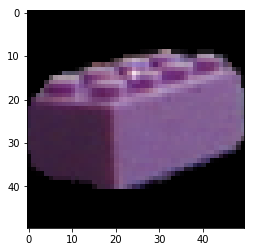

1
4


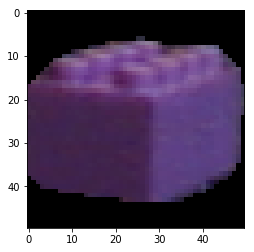

1
5


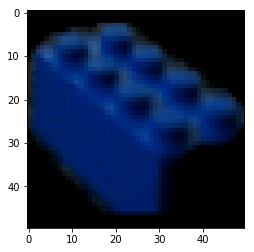

1
6


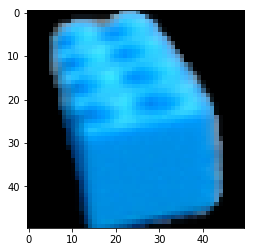

1
7


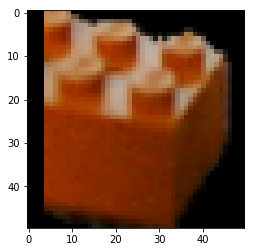

1
8


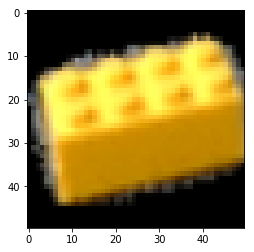

1
9


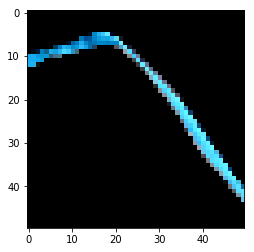

0
10


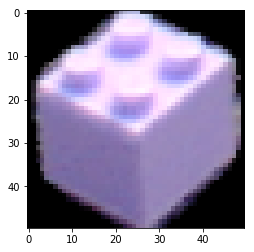

1
11


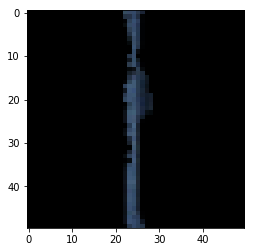

0
12


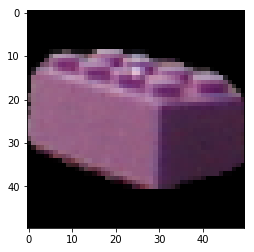

1
13


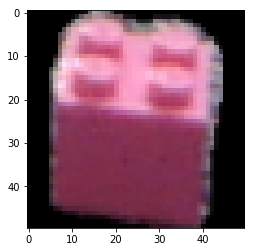

1
14


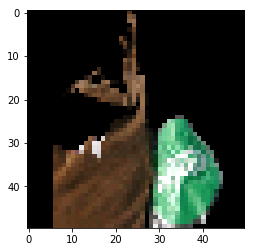

0
15


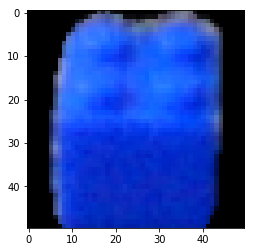

1
16


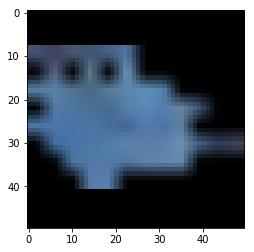

0
17


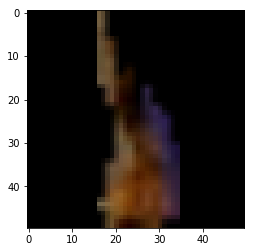

0
18


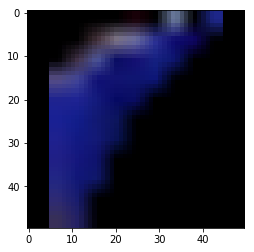

0
19


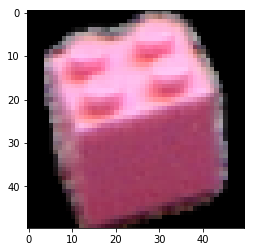

1
20


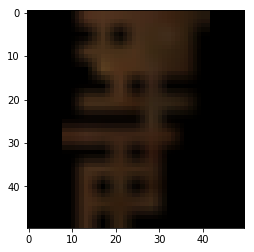

0
21


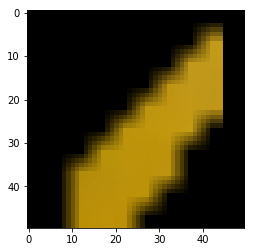

0
22


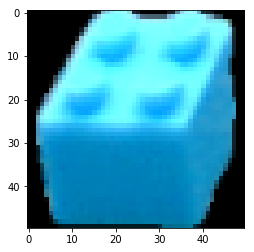

1
23


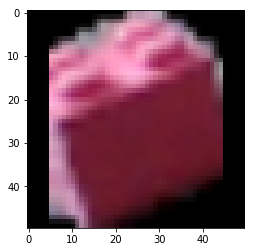

1
24


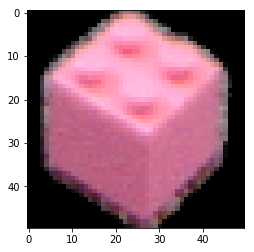

1
25


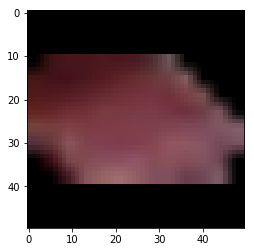

0
26


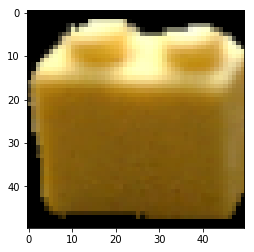

1
27


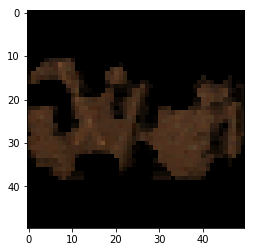

0
28


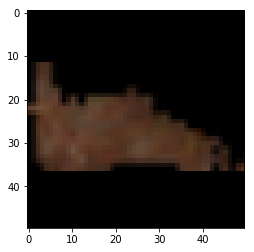

0
29


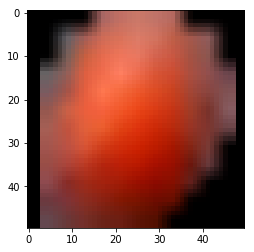

0
30


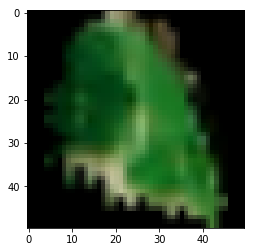

0
31


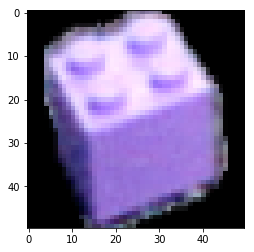

1
32


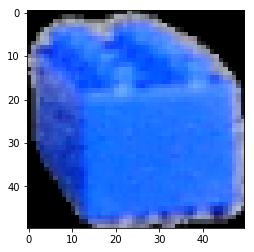

1
33


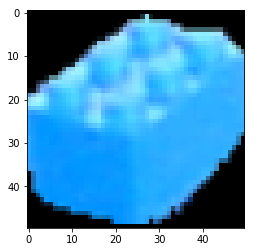

1
34


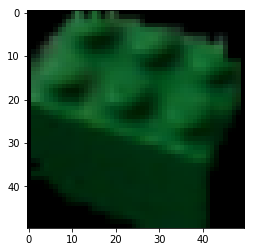

1
35


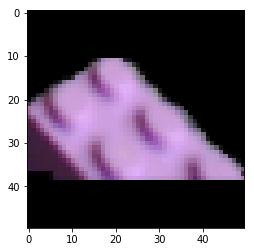

1
36


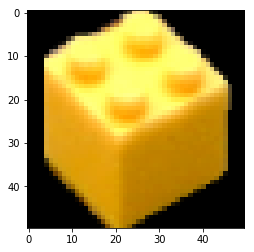

1
37


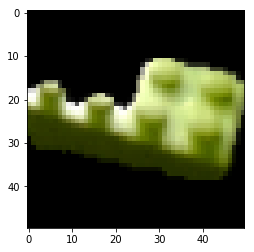

1
38


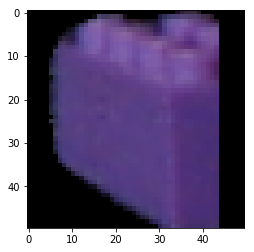

1
39


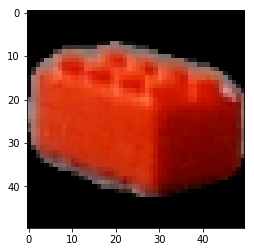

1
40


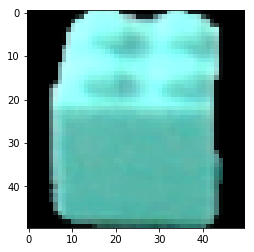

1
41


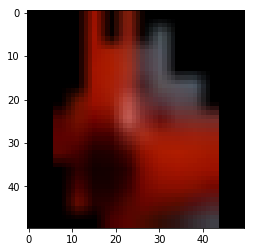

0
42


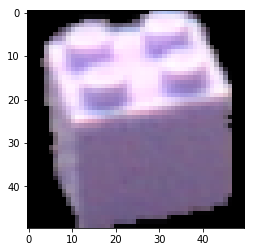

1
43


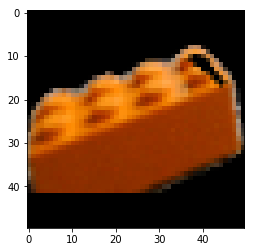

1
44


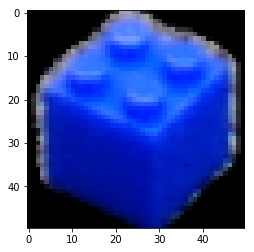

1
45


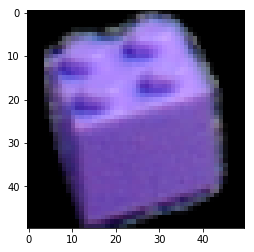

1
46


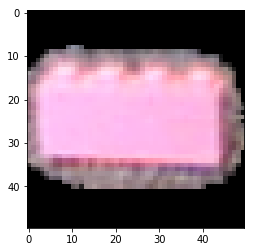

1
47


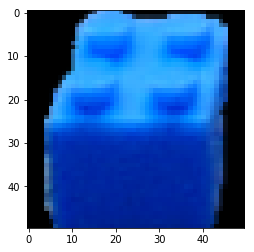

1
48


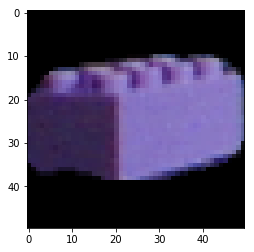

1
49


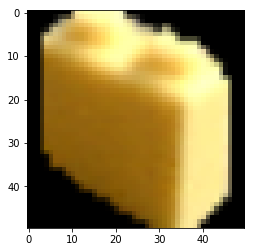

1
50


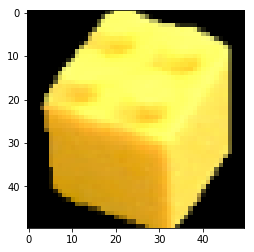

1
51


In [24]:
indices=np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset2=dataset[indices]
pixel_labels2=pixel_labels[indices]
count=0
for img,pre in zip(dataset2,pixel_labels2):
    #pdb.set_trace()
    plt.imshow(img*0.5+0.5)
    plt.show()
    print(pre)
    count+=1
    print(count)
    if count>50:
        break

In [35]:
print(tf.trainable_variables())

[<tf.Variable 'First_convolution/kernel:0' shape=(3, 3, 3, 8) dtype=float32_ref>, <tf.Variable 'First_convolution/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'Second_convolution/kernel:0' shape=(3, 3, 8, 4) dtype=float32_ref>, <tf.Variable 'Second_convolution/bias:0' shape=(4,) dtype=float32_ref>, <tf.Variable 'Predictions/kernel:0' shape=(2116, 2) dtype=float32_ref>, <tf.Variable 'Predictions/bias:0' shape=(2,) dtype=float32_ref>]


In [34]:
with tf.variable_scope("First_convolution", reuse=True): 
    x = tf.get_variable("kernel:0")

ValueError: Variable First_convolution/kernel:0 does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?